## 6 - Neural Scaling - MNIST example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import umap #pip install umap-learn ## Seems to work better on Linux
from torch.optim.lr_scheduler import StepLR

2025-10-30 14:08:48.318653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 16) #128)
        self.fc2 = nn.Linear(16, 10) #(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def get_penultimate_out(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def get_penulatimate_penultimate_out(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    losses=[]
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
def normalize_layout(layout, min_percentile=1, max_percentile=99, relative_margin=0.1):
    """Removes outliers and scales layout to between [0,1]."""

    # compute percentiles
    mins = np.percentile(layout, min_percentile, axis=(0))
    maxs = np.percentile(layout, max_percentile, axis=(0))

    # add margins
    mins -= relative_margin * (maxs - mins)
    maxs += relative_margin * (maxs - mins)

    # `clip` broadcasts, `[None]`s added only for readability
    clipped = np.clip(layout, mins, maxs)

    # embed within [0,1] along both axes
    clipped -= clipped.min(axis=0)
    clipped /= clipped.max(axis=0)

    return clipped

In [5]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,batch_size=64)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [6]:
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=0.05)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
device='cpu'

In [7]:
fc1_outs=[]
losses=[]
epoch=1
viz_period=5

for batch_idx, (data, target) in enumerate(train_loader):
    model.train()
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % viz_period == 0:
        losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            for data, target in test_loader:
                fc1_out=model.get_penultimate_out(data)
                break
        fc1_outs.append(fc1_out.numpy())

In [8]:
fc1_out.numpy().shape

(1000, 16)

In [9]:
# Interesting decision to make here about if we compute the mapping before during or after training
# Doing after training right now
u=umap.UMAP(n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine", random_state=0)
layout=u.fit_transform(fc1_out.numpy())
layout = normalize_layout(layout)

/home/stephen/anaconda3/envs/backprop/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stephen/anaconda3/envs/backprop/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_jobs=1, n_neighbors=20, random_state=0, verbose=True)
Thu Oct 30 14:10:58 2025 Construct fuzzy simplicial set
Thu Oct 30 14:10:59 2025 Finding Nearest Neighbors
Thu Oct 30 14:11:02 2025 Finished Nearest Neighbor Search
Thu Oct 30 14:11:04 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct 30 14:11:06 2025 Finished embedding


In [10]:
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        fc1_out=model.get_penultimate_out(data)
        # fc1_out=model.get_penulatimate_penultimate_out(data)
        break

In [11]:
fc1_out.shape

torch.Size([1000, 16])

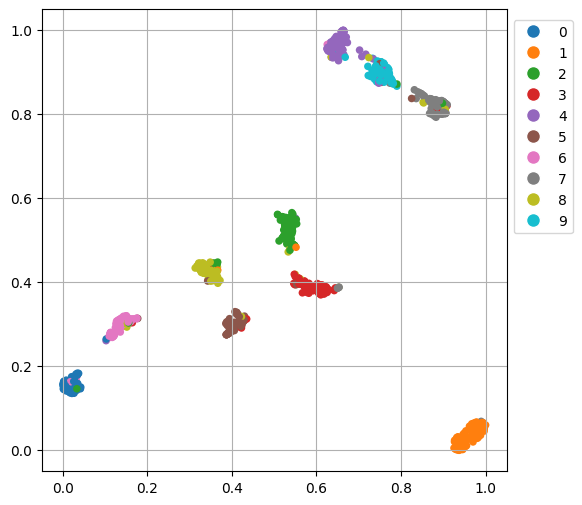

In [12]:
fig=plt.figure(0, (6,6), facecolor='w') 
ax=fig.add_subplot(111, facecolor='w') 
plt.scatter(layout[:,0], layout[:,1], c=target.numpy(), alpha=1.0, s=30, cmap='tab10', linewidth=0)
plt.grid(1)

legend_colors = plt.cm.tab10(np.arange(10))
legend_elements = [Line2D([0], [0], marker='o', color='w', alpha=1.0, markerfacecolor=legend_colors[i], markersize=10, label=str(i))
                   for i in range(10)]
plt.legend(handles=legend_elements, facecolor='w', loc='lower left', bbox_to_anchor=(1, 0.5))
plt.savefig('/home/stephen/book_exports/6_neural_scaling/mnist_after_training.svg', bbox_inches='tight')

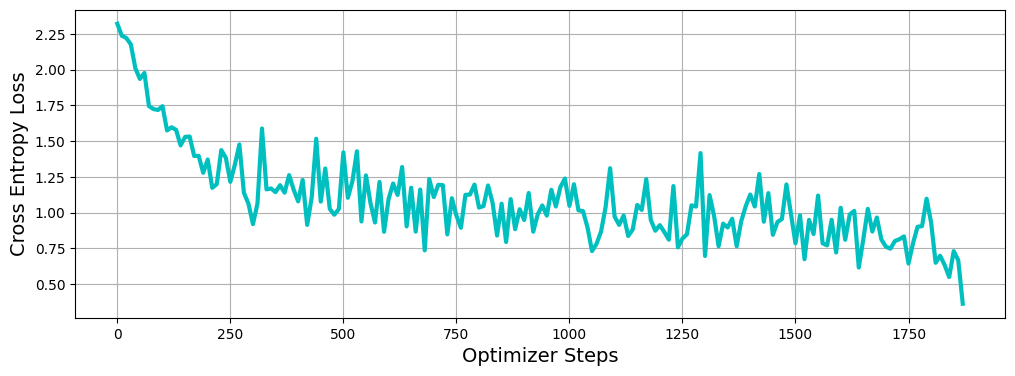

In [13]:
fig=plt.figure(0, (12,4), facecolor='w')
ax=fig.add_subplot(111, facecolor='w') 
plt.plot(10*np.arange(len(losses)), losses, color='c', linewidth=3)
plt.ylabel('Cross Entropy Loss', fontsize=14)
plt.xlabel('Optimizer Steps', fontsize=14)
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10) 
plt.grid(1)
plt.savefig('/home/stephen/book_exports/6_neural_scaling/training_curve.svg', bbox_inches='tight')

### Project points before training

In [14]:
layout = u.transform(fc1_outs[0])
layout = normalize_layout(layout)

/home/stephen/anaconda3/envs/backprop/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


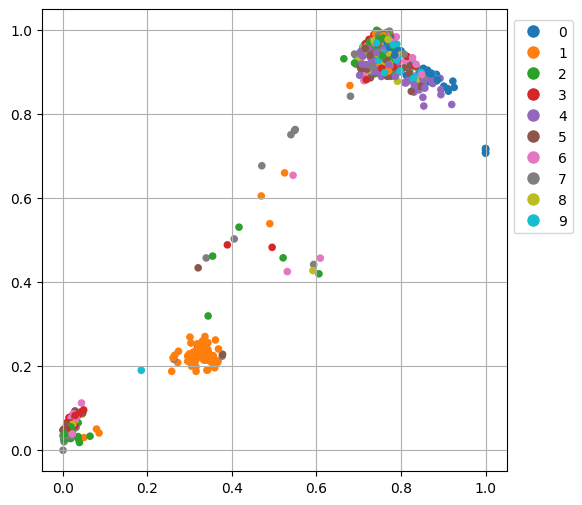

In [15]:
fig=plt.figure(0, (6,6), facecolor='w') 
ax=fig.add_subplot(111, facecolor='w') 
plt.scatter(layout[:,0], layout[:,1], c=target.numpy(), alpha=1.0, s=30, cmap='tab10', linewidth=0)
plt.grid(1)

legend_colors = plt.cm.tab10(np.arange(10))
legend_elements = [Line2D([0], [0], marker='o', color='w', alpha=1.0, markerfacecolor=legend_colors[i], markersize=10, label=str(i))
                   for i in range(10)]
plt.legend(handles=legend_elements, facecolor='w', loc='lower le ft', bbox_to_anchor=(1, 0.5))
plt.savefig('/home/stephen/book_exports/6_neural_scaling/mnist_before_training.svg', bbox_inches='tight')